In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy import integrate
import os

DIRNAME = os.path.abspath("")
PLOTS_PATH = os.path.join(DIRNAME, "Plots")

$\displaystyle \rho_{exp}(u)=\frac{\alpha}{2s}\Gamma^{-1}\left(\frac{1}{\alpha}\right)\exp\left(-\left|\frac{u}{s}\right|^{\alpha}\right)$

$\displaystyle F(u)=\int_{-\infty}^u\rho_{exp}(u')du'=1-\int_u^\infty\rho_{exp}(u')du'$

$\displaystyle F(u)=1-\int_{-\left|{\frac{u}{s}}\right|^{\alpha}}^\infty \frac{1}{2\Gamma\left(\frac{1}{\alpha}\right)}e^{-t} t^{\frac{1}{\alpha}-1}dt$

We can gather the gamma function with the upper incomplete boundary using the scipy package. Romberg integration from scipy import scipy.integrate

$\displaystyle F_G(u)=\frac{1}{2}\left[ 1+\operatorname{erf}\left(\frac{u^\beta}{\sqrt{2\sigma^2}}\right)\right]$

$\displaystyle D_{KL}= \sum_{x\in X}P(x)\operatorname{log}\left(\frac{P(x)}{Q(x)}\right)$

Kullback-Leibler divergence: 9.263
Integral difference        : 6.540


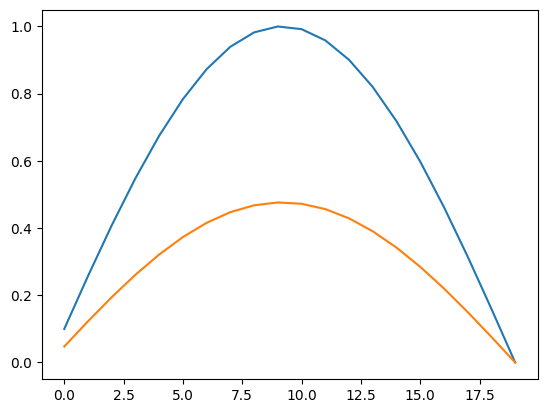

In [2]:
def kullback_leibler_divergence(p,q):
    return sum(p*np.log(p/q))

def integral_difference(p,q):
    return sum(p-q)


p = np.sin(np.linspace(0.1,np.pi, 20))
q = p/2.1
plt.plot(p)
plt.plot(q)

print(f"Kullback-Leibler divergence: {kullback_leibler_divergence(p,q):.3f}")
print(f"Integral difference        : {integral_difference(p,q):.3f}")

The upper incomplete gamma function is defined as:

$\displaystyle \Gamma(\alpha, x) = \int_x^\infty t^{\alpha-1} e^{-t}\mathrm{d}t$

Our rearrangement is defined as:

$\displaystyle Q\left(\alpha,x\right)=\frac{1}{\Gamma\left(\alpha\right)}\int_{x}^\infty t^{\alpha-1}e^{-t}dt$

$\displaystyle \frac{1}{2}Q\left(\frac{1}{\alpha},\left|\frac{u}{s}\right|^\alpha\right):=\frac{1}{2\Gamma\left(\frac{1}{\alpha}\right)}\Gamma\left(\frac{1}{\alpha},\left|\frac{u}{s}\right|^\alpha\right)$

$\displaystyle F_{exp}(u) = \begin{cases} \frac{1}{2}Q\left(\frac{1}{\alpha},\frac{u}{s}^\alpha\right) & u < 0 \\
1 - \frac{1}{2}Q\left(\frac{1}{\alpha},\left|\frac{u}{s}\right|^\alpha\right) & u \ge 0 \end{cases}$

In [3]:
def get_var(alpha, s, beta): return s**(2*beta) * special.gamma((2*beta+1)/alpha) / special.gamma(1/alpha)

def u_transform_w(u, beta): return np.sign(u) * np.power(np.abs(u), beta)

def gaussian_pdf(w, var):
    return 1 / (var * np.sqrt((2 * np.pi)) * np.exp(-(1/2) * np.power(w/var,2)))

def gaussian_distr(w, var):
    return 0.5 * (1 + special.erf(w / np.sqrt(2*var)))


def sym_stretched_exp_pdf(u, alpha, s):
    return alpha / (2 * s * special.gamma(1/alpha)) * np.exp(-(np.power(np.abs(u/s), alpha)))

def sym_stretched_exp_distr(u, alpha, s): 
    return np.piecewise(u, [u<0, u>=0], [
                            lambda u: 0.5 * special.gammaincc(1/alpha, np.power(np.abs(u/s), alpha)),
                            lambda u: 1 - 0.5 * special.gammaincc(1/alpha, np.power(np.abs(u/s), alpha))])

def lambda_distance(u, alpha, s, beta):
    var = get_var(alpha=alpha, s=s, beta=beta)
    w = u_transform_w(u=u, beta=beta)
    F_exp = sym_stretched_exp_distr(u=u, alpha=alpha, s=s)
    F_g = gaussian_distr(w, var)
    return (F_exp - F_g)**2


In [4]:
from tqdm import tqdm

alpha_arr = np.linspace(0.4,2.5,50) # [0.755] #
scale_arr = np.linspace(0.1,0.2,2) # [0.137] #
beta_arr = np.linspace(0.2,2, 300)

#keys = [(alpha, s) for alpha in alpha_arr for s in scale_arr]
beta_opts = []#dict.fromkeys(keys, 0)


for alpha in tqdm(alpha_arr):
    for s in scale_arr:
        lambdas = [2 * integrate.quad(lambda_distance, a=0, b=np.inf, args=(alpha, s, b))[0] for b in beta_arr]
        beta_opts.append(beta_arr[np.argmin(lambdas)])


100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


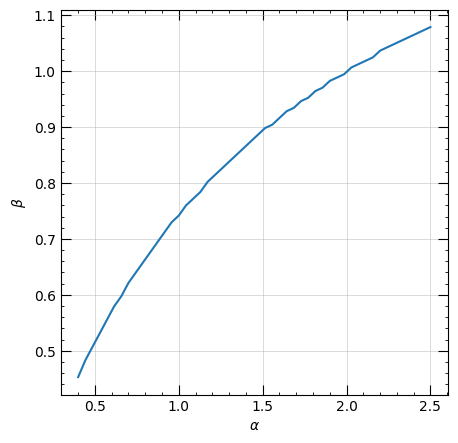

In [5]:
_ = plt.figure(figsize=(5,5))

plt.plot(alpha_arr, np.array(beta_opts[::2]))
plt.ylabel(r"$\beta$")
plt.xlabel(r"$\alpha$")

plt.grid(linewidth=0.4, alpha=0.8)

plt.minorticks_on()
plt.tick_params(direction="in", which="major", length=7, bottom=True, top=True, right=True)
plt.tick_params(direction="in", which="minor", length=2.5, bottom=True, top=True, right=True)

In [6]:
import pandas as pd
df = pd.DataFrame(data=np.array(beta_opts).reshape(50,2), index=alpha_arr, columns=scale_arr)


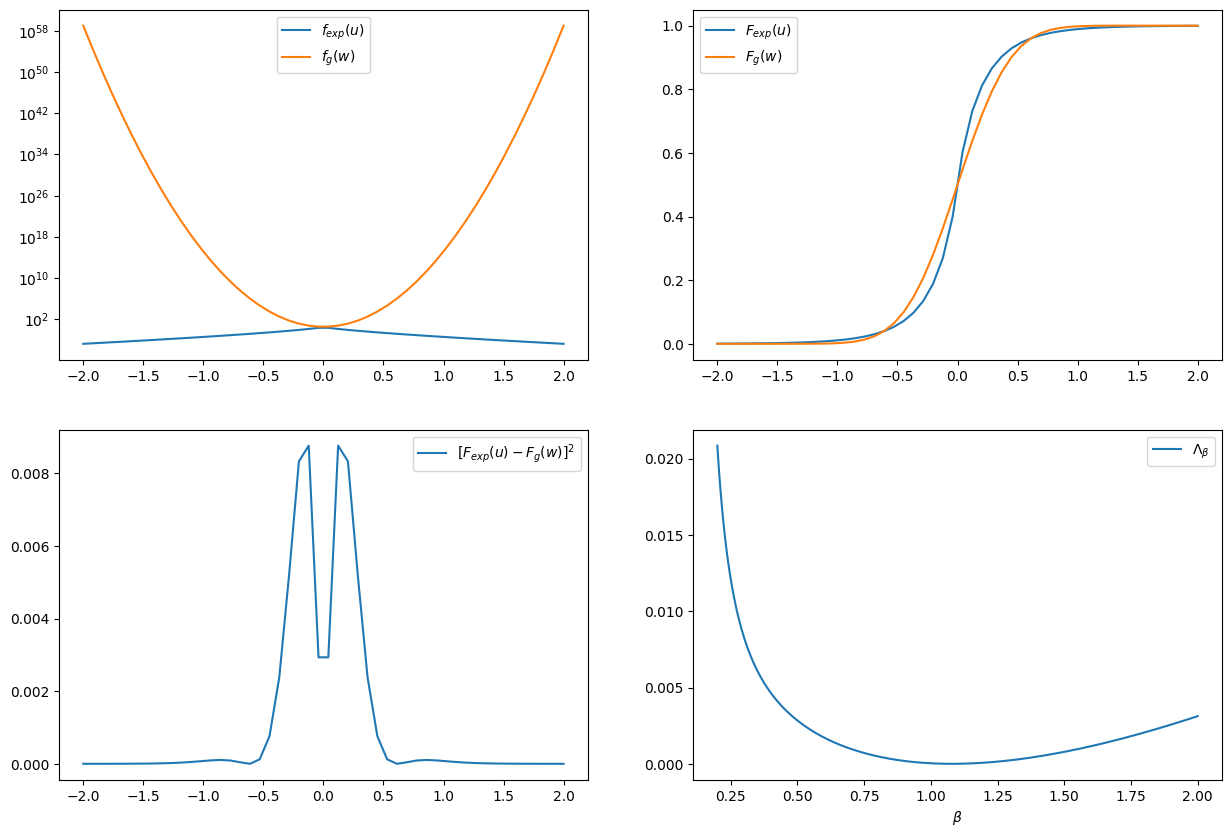

In [15]:
x = np.linspace(-2, 2, 50)

alpha = 0.755
s = 0.137
beta = 1

_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,10))   

ax1.plot(x, sym_stretched_exp_pdf(x, alpha, s), label="$f_{exp}(u)$")
ax1.plot(x, gaussian_pdf(x, var=get_var(alpha, s, beta)), label="$f_g(w)$")
ax1.legend()
ax1.set_yscale("log")

ax2.plot(x, sym_stretched_exp_distr(x, alpha, s), label="$F_{exp}(u)$")
ax2.plot(x, gaussian_distr(x, var=get_var(alpha, s, beta)), label="$F_g(w)$")
ax2.legend()

ax3.plot(x, lambda_distance(x, alpha, s, beta), label="$[F_{exp}(u)-F_g(w)]^2$")
ax3.legend()

ax4.plot(beta_arr, lambdas, label=r"$\Lambda_\beta$")
ax4.set_xlabel(r"$\beta$")
ax4.legend()


plt.savefig(os.path.join(PLOTS_PATH, "GaussTrafo.png"))

$\displaystyle \sigma(\alpha, \beta, s) = 2\int_{0}^\infty u^{2\beta} p(u) \,\mathrm{d}u$

$\displaystyle = 2\int_{0}^\infty u^{2\beta} \frac{a}{2s}\frac{1}{\Gamma\left(\frac{1}{\alpha}\right)}\exp{\left({-\left|\frac{u}{s}\right|}^\alpha\right)} \,\mathrm{d}u$

$\displaystyle t:=\left|\frac{u}{s}\right|^\alpha$

$\displaystyle u=t^{\frac{1}{\alpha}}s$

$\displaystyle \mathrm{d}u = \frac{s}{\alpha} t^{\frac{1}{\alpha}-1} $

$\displaystyle = \frac{a}{2s}\frac{2}{\Gamma\left(\frac{1}{\alpha}\right)} \int_{0}^\infty \left(t^{\frac{1}{\alpha}}s\right)^{2\beta} \exp({-t}) \frac{s}{\alpha} t^{\frac{1}{\alpha}-1} \,\mathrm{d}t$

$\displaystyle = s^{2\beta} \frac{1}{\Gamma\left(\frac{1}{\alpha}\right)} \int_{0}^\infty \left(t^{\frac{1}{\alpha}}\right)^{2\beta} \exp({-t}) t^{\frac{1}{\alpha}-1} \,\mathrm{d}t $

$\displaystyle = s^{2\beta} \frac{1}{\Gamma\left(\frac{1}{\alpha}\right)} \int_{0}^\infty \exp({-t}) t^{\frac{1}{\alpha}-1} t^{\frac{2\beta}{\alpha}} \,\mathrm{d}t $

$\displaystyle =  s^{2\beta}\frac{1}{\Gamma\left(\frac{1}{\alpha}\right)} \int_{0}^\infty \exp({-t}) t^{\frac{1}{\alpha}-1+\frac{2\beta}{\alpha}} \,\mathrm{d}t $

$\displaystyle = s^{2\beta} \frac{1}{\Gamma\left(\frac{1}{\alpha}\right)}\int_{0}^\infty \exp({-t}) t^{\frac{2\beta+1}{\alpha}-1}\, \mathrm{d}t $

$\displaystyle = s^{2\beta} \frac{\Gamma\left(\frac{2\beta+1}{\alpha}\right)}{\Gamma\left(\frac{1}{\alpha}\right)} $